<h1>Rag from Scratch: Query Construction</h1>

In [15]:
#pip install yt-dlp youtube-transcript-api

<h2>Environment

In [16]:
from dotenv import load_dotenv
import os

load_dotenv(".env")
openai_api_key = os.getenv("OPENAI_API_KEY")
langsmith_api_key = os.getenv("LANGCHAIN_API_KEY")

os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGSMITH_PROJECT'] ="RAG_Multi_Query"
os.environ['LANGCHAIN_API_KEY'] = langsmith_api_key
os.environ['OPENAI_API_KEY'] = openai_api_key

<h2>Part 11: Query structuring for metadata filters

Flow:

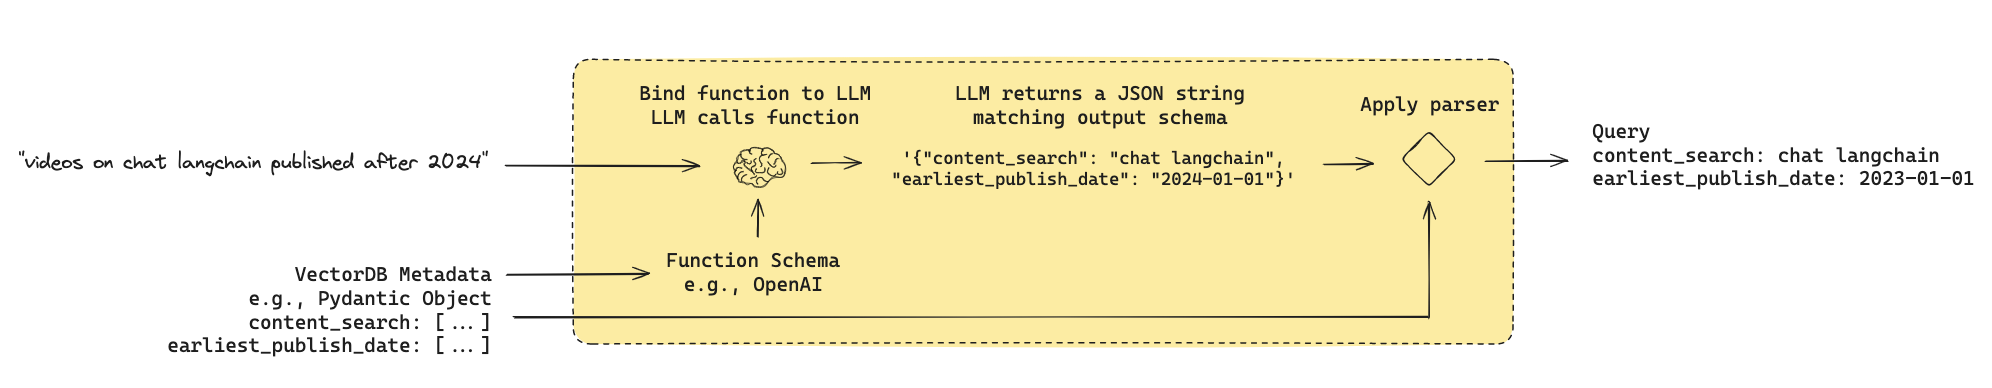

Many vectorstores contain metadata fields.

This makes it possible to filter for specific chunks based on metadata.

Let's look at some example metadata we might see in a database of YouTube transcripts.

In [17]:
import yt_dlp
from youtube_transcript_api import YouTubeTranscriptApi
from datetime import datetime

def get_youtube_metadata(video_url):
    """Fetches video metadata using yt-dlp."""
    ydl_opts = {"quiet": True, "noplaylist": True}
    
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(video_url, download=False)
    
    metadata = {
        "source": info["id"],
        "title": info.get("title", "Unknown"),
        "description": info.get("description", "Unknown"),
        "view_count": info.get("view_count", 0),
        "thumbnail_url": info.get("thumbnail", ""),
        "publish_date": str(datetime.utcfromtimestamp(info.get("timestamp", 0))) if info.get("timestamp") else "Unknown",
        "length": info.get("duration", 0),
        "author": info.get("uploader", "Unknown"),
    }
    return metadata

def get_youtube_transcript(video_id):
    """Fetches the video transcript using youtube-transcript-api."""
    try:
        transcript = YouTubeTranscriptApi.get_transcript(video_id)
        text = " ".join([entry["text"] for entry in transcript])
        return text
    except Exception as e:
        return f"Transcript unavailable: {e}"

# Test with your video
video_url = "https://www.youtube.com/watch?v=pbAd8O1Lvm4"
metadata = get_youtube_metadata(video_url)
#metadata["transcript"] = get_youtube_transcript(metadata["source"])

# Print metadata
print(metadata)


{'source': 'pbAd8O1Lvm4', 'title': 'Self-reflective RAG with LangGraph: Self-RAG and CRAG', 'description': 'Self-reflection can greatly enhance RAG, enabling correction of poor quality retrieval or generations. Several recent RAG papers focus on this theme, but implementing the ideas can be tricky. Here, we show that LangGraph can be easily used for "flow engineering" of self-reflective RAG pipelines. We provide cookbooks for implementing ideas from two interesting papers, Self-RAG and C-RAG.\n\nCode:\nhttps://github.com/langchain-ai/langgraph/tree/main/examples/rag', 'view_count': 29586, 'thumbnail_url': 'https://i.ytimg.com/vi/pbAd8O1Lvm4/maxresdefault.jpg', 'publish_date': '2024-02-07 16:46:59', 'length': 1058, 'author': 'LangChain'}


C:\Users\Linh\AppData\Local\Temp\ipykernel_31660\2853566667.py:18: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "publish_date": str(datetime.utcfromtimestamp(info.get("timestamp", 0))) if info.get("timestamp") else "Unknown",


Let’s assume we’ve built an index that:

1. Allows us to perform unstructured search over the contents and title of each document
2. And to use range filtering on view count, publication date, and length.
We want to convert natural langugae into structured search queries.

We can define a schema for structured search queries.

In [18]:
import datetime
from typing import Literal, Optional, Tuple
from langchain_core.pydantic_v1 import BaseModel, Field

class TutorialSearch(BaseModel):
    """Search over a database of tutorial videos about a software library."""

    content_search: str = Field(
        ...,
        description="Similarity search query applied to video transcripts.",
    )
    title_search: str = Field(
        ...,
        description=(
            "Alternate version of the content search query to apply to video titles. "
            "Should be succinct and only include key words that could be in a video "
            "title."
        ),
    )
    min_view_count: Optional[int] = Field(
        None,
        description="Minimum view count filter, inclusive. Only use if explicitly specified.",
    )
    max_view_count: Optional[int] = Field(
        None,
        description="Maximum view count filter, exclusive. Only use if explicitly specified.",
    )
    earliest_publish_date: Optional[datetime.date] = Field(
        None,
        description="Earliest publish date filter, inclusive. Only use if explicitly specified.",
    )
    latest_publish_date: Optional[datetime.date] = Field(
        None,
        description="Latest publish date filter, exclusive. Only use if explicitly specified.",
    )
    min_length_sec: Optional[int] = Field(
        None,
        description="Minimum video length in seconds, inclusive. Only use if explicitly specified.",
    )
    max_length_sec: Optional[int] = Field(
        None,
        description="Maximum video length in seconds, exclusive. Only use if explicitly specified.",
    )

    def pretty_print(self) -> None:
        for field in self.__fields__:
            if getattr(self, field) is not None and getattr(self, field) != getattr(
                self.__fields__[field], "default", None
            ):
                print(f"{field}: {getattr(self, field)}")

Now, we prompt the LLM to produce queries.

In [19]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

system = """You are an expert at converting user questions into database queries. \
You have access to a database of tutorial videos about a software library for building LLM-powered applications. \
Given a question, return a database query optimized to retrieve the most relevant results.

If there are acronyms or words you are not familiar with, do not try to rephrase them."""
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
structured_llm = llm.with_structured_output(TutorialSearch)
query_analyzer = prompt | structured_llm

c:\Users\Linh\AppData\Local\Programs\Python\Python312\Lib\site-packages\langchain_openai\chat_models\base.py:1360: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(
c:\Users\Linh\AppData\Local\Programs\Python\Python312\Lib\site-packages\langchain_openai\chat_models\base.py:1373: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo-0125 since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


In [20]:
query_analyzer.invoke({"question": "rag from scratch"}).pretty_print()

content_search: rag from scratch
title_search: rag from scratch


In [21]:
query_analyzer.invoke(
    {"question": "videos on chat langchain published in 2023"}
).pretty_print()

content_search: chat langchain
title_search: 2023
earliest_publish_date: 2023-01-01
latest_publish_date: 2024-01-01


In [22]:
query_analyzer.invoke(
    {"question": "videos that are focused on the topic of chat langchain that are published before 2024"}
).pretty_print()

content_search: chat langchain
title_search: chat langchain
latest_publish_date: 2024-01-01


In [23]:
query_analyzer.invoke(
    {
        "question": "how to use multi-modal models in an agent, only videos under 5 minutes"
    }
).pretty_print()

content_search: multi-modal models agent
title_search: multi-modal models agent
max_length_sec: 300
